#  IN4050 Mandatory Assignment 1: Traveling Salesman Problem


## Rules
Before you begin the exercise, review the rules at this website:
https://www.uio.no/english/studies/examinations/compulsory-activities/mn-ifi-mandatory.html
(This is an individual assignment. You are not allowed to deliver together or copy/share source-code/answers
with others.)

Especially, notice that you are **not allowed to use code or parts of code written by others** in your submission. We do check your code against online repositories, so please be sure to **write all the code yourself**. Any use of **auto-generated code** must be clearly identified, along with the tool or software used to generate it. Read also the "Routines for handling suspicion of cheating and attempted cheating at the University of Oslo": https://www.uio.no/english/studies/examinations/cheating/index.html By submitting this assignment, you confirm that you are familiar with the rules and the consequences of breaking them.

### Delivery

**Deadline**: Tuesday, October 8 2024, 23:59

Your submission should be delivered in Devilry. You may redeliver in Devilry before the deadline, but include all files in the last delivery, as only the last delivery will be read. You are recommended to upload preliminary versions hours (or days) before the final deadline.

## What to deliver?

Deliver one single zipped folder (.zip, .tgz or .tar.gz) which includes:
* PDF report containing:
    * Your name and username (!)
    * Instructions on how to run your program, with example runs.
    * Answers to all questions from assignment.
    * Brief explanation of what you’ve done.
    * *Your PDF may be generated by exporting your Jupyter Notebook to PDF, if you have answered all questions in your notebook*
* Source code
    * Source code may be delivered as jupyter notebooks or python files (.py)
* The european cities file so the program will run right away.
* Any files needed for the group teacher to easily run your program on IFI linux machines.

**Important**: 
* Include example runs of your code by doing the reports described in the tasks. Simply implementing the code, but never running it will not give many points.
* Include the code that was used to make all reports. Do not include reports of performance and time without also including the code that was used to produce it.
* If you weren’t able to finish the assignment, use the PDF report to elaborate on what you’ve tried
and what problems you encountered. Students who have made an effort and attempted all parts of the assignment
will get a second chance even if they fail initially. This exercise will be graded PASS/FAIL.

## Introduction
In this exercise, you will attempt to solve an instance of the traveling salesman problem (TSP) using different
methods. The goal is to become familiar with evolutionary algorithms and to appreciate their effectiveness on a
difficult search problem. You have to use Python to solve the assignment. You must write
your program from scratch (but you may use non-EA-related libraries).


|  &nbsp;   | Barcelona | Belgrade |  Berlin | Brussels | Bucharest | Budapest |
|:---------:|:---------:|:--------:|:-------:|:--------:|:---------:|:--------:|
| Barcelona |     0     |  1528.13 | 1497.61 |  1062.89 |  1968.42  |  1498.79 |
|  Belgrade |  1528.13  |     0    |  999.25 |  1372.59 |   447.34  |  316.41  |
|   Berlin  |  1497.61  |  999.25  |    0    |  651.62  |  1293.40  |  1293.40 |
|  Brussels |  1062.89  |  1372.59 |  651.62 |     0    |  1769.69  |  1131.52 |
| Bucharest |  1968.42  |  447.34  | 1293.40 |  1769.69 |     0     |  639.77  |
|  Budapest |  1498.79  |  316.41  | 1293.40 |  1131.52 |   639.77  |     0    |


<center>Figure 1: First 6 cities from csv file.</center>


## Problem
The traveling salesman, wishing to disturb the residents of the major cities in some region of the world in
the shortest time possible, is faced with the problem of finding the shortest tour among the cities. A tour
is a path that starts in one city, visits all of the other cities, and then returns to the starting point. The
relevant pieces of information, then, are the cities and the distances between them. In this instance of the
TSP, a number of European cities are to be visited. Their relative distances are given in the data file, *european_cities.csv*, found in the zip file with the mandatory assignment.

(You will use permutations to represent tours in your programs. The **itertools** module in Python provides
a permutations function that returns successive permutations, this is useful for exhaustive search)

## Helper code for visualizing solutions

Here follows some helper code that you can use to visualize the plans you generate. These visualizations can **help you check if you are making sensible tours or not**. The optimization algoritms below should hopefully find relatively nice looking tours, but perhaps with a few visible inefficiencies.

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import time
import pandas as pd
import itertools as it
import random
random.seed(99)

%matplotlib inline
np.random.seed(57)
#Map of Europe
europe_map = plt.imread('map.png')

#Lists of city coordinates
city_coords = {
    "Barcelona": [2.154007, 41.390205], "Belgrade": [20.46, 44.79], "Berlin": [13.40, 52.52], 
    "Brussels": [4.35, 50.85], "Bucharest": [26.10, 44.44], "Budapest": [19.04, 47.50],
    "Copenhagen": [12.57, 55.68], "Dublin": [-6.27, 53.35], "Hamburg": [9.99, 53.55], 
    "Istanbul": [28.98, 41.02], "Kyiv": [30.52, 50.45], "London": [-0.12, 51.51], 
    "Madrid": [-3.70, 40.42], "Milan": [9.19, 45.46], "Moscow": [37.62, 55.75],
    "Munich": [11.58, 48.14], "Paris": [2.35, 48.86], "Prague": [14.42, 50.07],
    "Rome": [12.50, 41.90], "Saint Petersburg": [30.31, 59.94], "Sofia": [23.32, 42.70],
    "Stockholm": [18.06, 60.33], "Vienna": [16.36, 48.21], "Warsaw": [21.02, 52.24]}


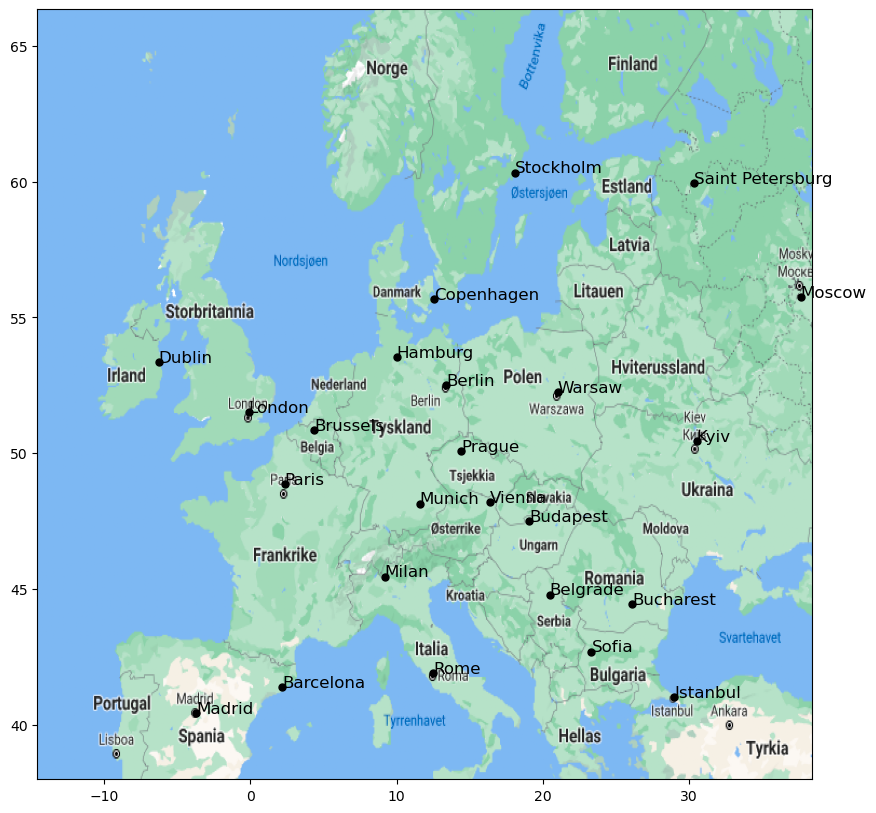

In [14]:
#Helper code for plotting plans
#First, visualizing the cities.
import csv
with open("european_cities.csv", "r") as f:
    data = list(csv.reader(f, delimiter=';'))
    cities = data[0]

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(europe_map, extent=[-14.56, 38.43, 37.697 + 0.3, 64.344 + 2.0], aspect="auto")

# Map (long, lat) to (x, y) for plotting
for city, location in city_coords.items():
    x, y = (location[0], location[1])
    plt.plot(x, y, 'ok', markersize=5)
    plt.text(x, y, city, fontsize=12)


In [15]:
#A method you can use to plot your plan on the map.
def plot_plan(city_order):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(europe_map, extent=[-14.56, 38.43, 37.697 + 0.3, 64.344 + 2.0], aspect="auto")

    # Map (long, lat) to (x, y) for plotting
    for index in range(len(city_order) - 1):
        current_city_coords = city_coords[city_order[index]]
        next_city_coords = city_coords[city_order[index+1]]
        x, y = current_city_coords[0], current_city_coords[1]
        #Plotting a line to the next city
        next_x, next_y = next_city_coords[0], next_city_coords[1]
        plt.plot([x, next_x], [y, next_y])

        plt.plot(x, y, 'ok', markersize=5)
        plt.text(x, y, index, fontsize=12)
    #Finally, plotting from last to first city
    first_city_coords = city_coords[city_order[0]]
    first_x, first_y = first_city_coords[0], first_city_coords[1]
    plt.plot([next_x, first_x], [next_y, first_y])
    #Plotting a marker and index for the final city
    plt.plot(next_x, next_y, 'ok', markersize=5)
    plt.text(next_x, next_y, index+1, fontsize=12)
    plt.show()


['Barcelona', 'Belgrade', 'Berlin', 'Brussels', 'Bucharest', 'Budapest', 'Copenhagen', 'Dublin', 'Hamburg', 'Istanbul', 'Kyiv', 'London', 'Madrid', 'Milan', 'Moscow', 'Munich', 'Paris', 'Prague', 'Rome', 'Saint Petersburg', 'Sofia', 'Stockholm', 'Vienna', 'Warsaw']


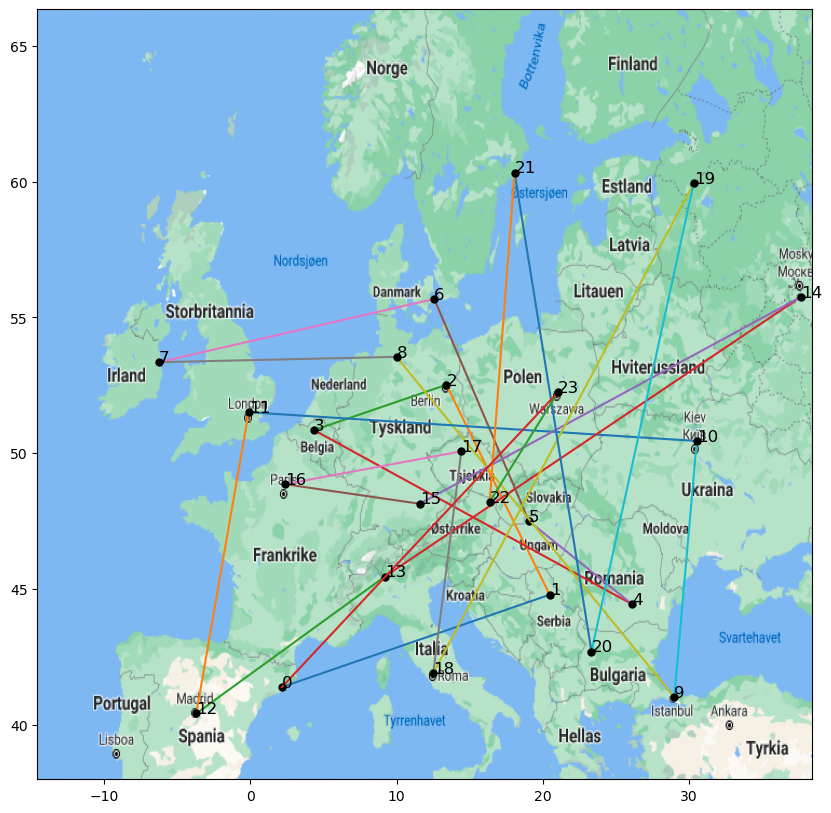

In [16]:
#Example usage of the plotting-method.
plan = list(city_coords.keys()) # Gives us the cities in alphabetic order
print(plan)
plot_plan(plan)

## Exhaustive Search
First, try to solve the problem by inspecting every possible tour. Start by writing a program to find the shortest
tour among a subset of the cities (say, **6** of them). Measure the amount of time your program takes. Incrementally
add more cities and observe how the time increases. Plot the shortest tours you found using the plot_plan method above, for 6 and 10 cities.

**Note:** To get distances between cities, use the dictionary `data` created by reading the file `european_cities.csv`. *Do not* calculate distances based on the coordinates. The actual distances do not only depend on the differences in the coordinates, but also of the curvature of the earth. The distances available in `data` are corrected for this, and contain the actual true distances.

In [17]:

# Number of cities
n1 = 6
n2 = 10
n3 = 24

df = pd.read_csv("european_cities.csv", delimiter=';')

# Data in numpy array, used in calc distance
dist_m = df.to_numpy()

# Want to create map of cities to index, to map route later
cities = df.columns.tolist()
cities_dict = {}
for i in range(len(cities)):
    cities_dict[i] = cities[i]
#print(cities_dict)

#List of cities in a path, represented by ints
cities_6 = np.linspace(0, n1-1, n1, dtype='int')
cities_10 = np.linspace(0, n2-1, n2, dtype='int')
cities_24 = np.linspace(0, n3-1, n3, dtype='int')

#Generate all permutations for exhaustive search (also used in hill climb, sampled for starting path)
permutations_6 = it.permutations(cities_6)
permutations_10 = it.permutations(cities_10)

perm_6 = []
perm_10 = []

for perm in permutations_6:
    perm_6.append(perm)
    
for perm in permutations_10:
    perm_10.append(perm)


# For 24 cities, dont need all permutations. Instead generate just n samples.
def gen_perm(cities, n):
    perms = []
    cities_ = list(cities) # swap to list to make use of sample
    m = len(cities)
    for i in range(n):
        perm = random.sample(cities_, m) # E.g for 24 cities: Sample without replacement from cities list 24 times.
        perms.append(perm)
    return perms

perm_24 = gen_perm(cities_24, int(1e3)) #only need 20, but create more for testing


In [18]:
#Functions to find distance and fitness

# (row, column), e.g Barcelona distance to Belgrade -> dist_m[1, 0]

def calc_distance(cities):
    '''
    Input:
        - cities (list) : Vector with unique number representing corresponding city
    
    Output:
        - distance (float) : Total distance, where larger is worse.
    '''
    distance = 0
    for i in range(len(cities)-1):
        distAB = dist_m[cities[i], cities[i+1]]
        distance += distAB
    distance += dist_m[cities[-1], cities[0]] #return to starting point

    return distance


def fitness(distance):
    return 1/distance


def exhaustive_search(perms):
    best_path = []
    best_distance = 1e6
    for perm in perms:
        dist = calc_distance(perm)  
        if dist < best_distance:
            best_path = perm         
            best_distance = dist

    return best_path, best_distance

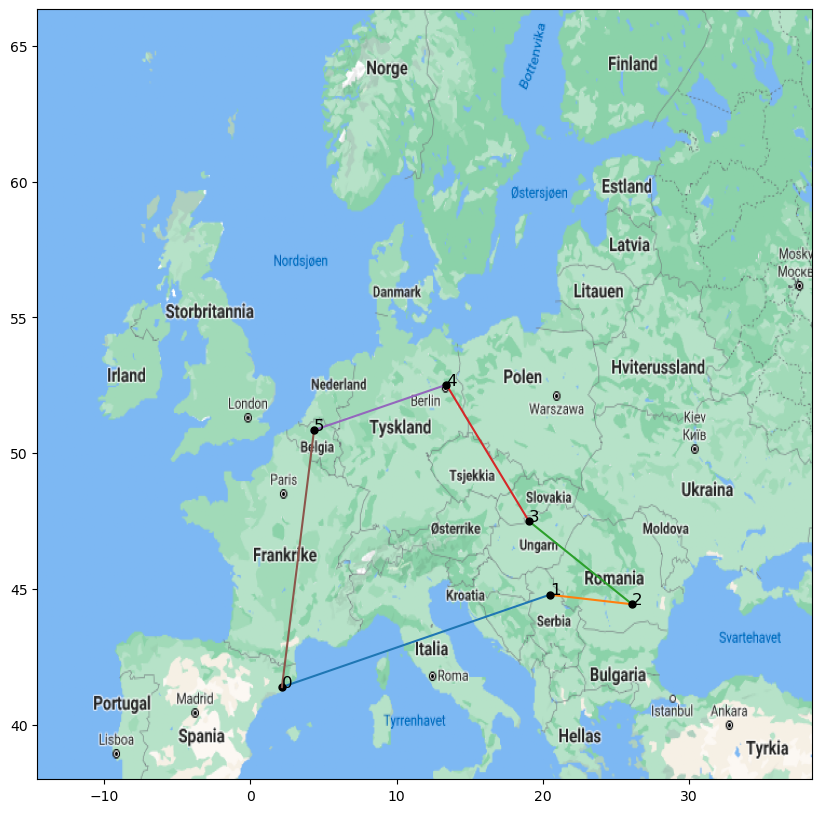

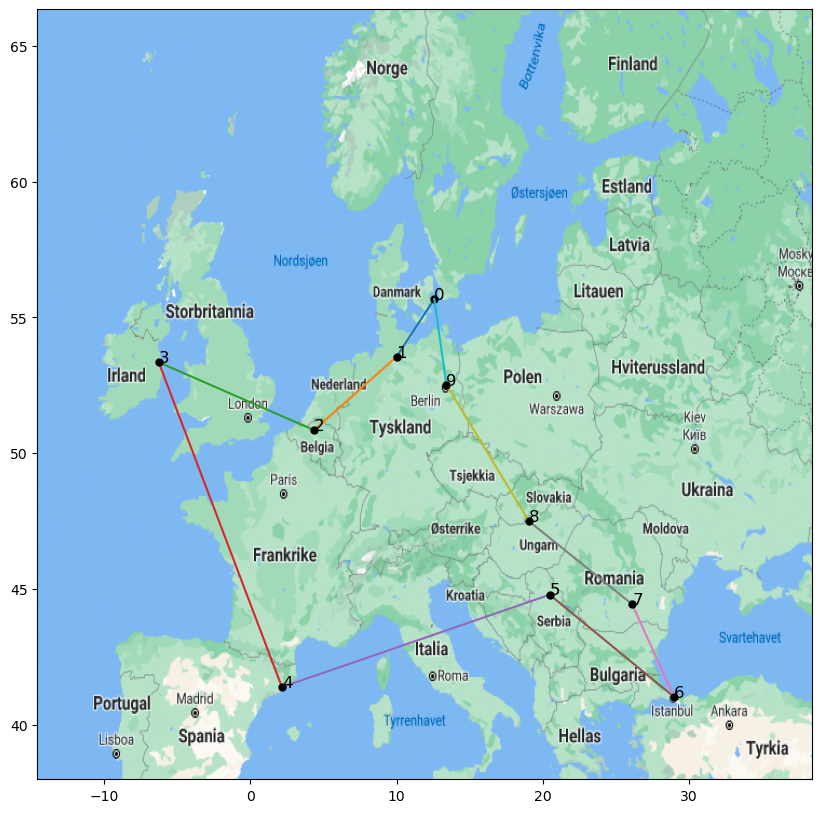

In [19]:


# Find all differnet combination of 6 and 10 cities and calculate best path


start_time = time.time()
p6, d6 = exhaustive_search(perm_6)
end_time = time.time()
p6_time = end_time - start_time


start_time = time.time()
p10, d10 = exhaustive_search(perm_10)
end_time = time.time()
p10_time = end_time - start_time


def path_toCities(path):
    # Input list/arr of ints and convert to strings
    return [cities_dict[i] for i in path]

def plot_path(path):
    #Plots path given input as ints
    path = path_toCities(path)
    plot_plan(path)

plot_path(p6)
plot_path(p10)



What is the shortest tour (i.e., the actual sequence of cities, and its length) among the first 10 cities (that is,
the cities starting with B,C,D,H and I)? How long did your program take to find it? Calculate an approximation of how long it would take to perform exhaustive search on all 24 cities?

In [20]:
# Answer
print(f"Time for 6 cities: {p6_time:.4f} seconds")
print(f"Time for 10 cities: {p10_time:.4f} seconds")
print(f"Relative increase: Cities {(10/6):.2f}, Time increase(p10/p6): {(p10_time/(p6_time+1e-5)):.2f}\n") #avoid 0 division, added eps

print(f"Six cities: path: {path_toCities(p6)}, distance: {d6:.2f}")
print(f"Ten cities: path: {path_toCities(p10)}, distance: {d10:.2f}")

#Calculate 24 cities time

Time for 6 cities: 0.0015 seconds
Time for 10 cities: 5.5774 seconds
Relative increase: Cities 1.67, Time increase(p10/p6): 3681.12

Six cities: path: ['Barcelona', 'Belgrade', 'Bucharest', 'Budapest', 'Berlin', 'Brussels'], distance: 5018.81
Ten cities: path: ['Copenhagen', 'Hamburg', 'Brussels', 'Dublin', 'Barcelona', 'Belgrade', 'Istanbul', 'Bucharest', 'Budapest', 'Berlin'], distance: 7486.31


## Hill Climbing
Then, write a simple hill climber to solve the TSP. How well does the hill climber perform, compared to the result from the exhaustive search for the first **10 cities**? Since you are dealing with a stochastic algorithm, you
should run the algorithm several times to measure its performance. Report the length of the tour of the best,
worst and mean of 20 runs (with random starting tours), as well as the standard deviation of the runs, both with the **10 first cities**, and with all **24 cities**. Plot one of the the plans from the 20 runs for both 10 cities and 24 cities (you can use plot_plan). 

For 6 cities:
Best distance: 5019, worst distance: 5019
Best path: [5 4 1 0 3 2]
Mean: 5018.81 , STD: 0.00

For 10 cities:
Best distance: 7486, worst distance: 8347
Best path: [5 2 6 8 3 7 0 1 9 4]
Mean: 7575.48 , STD: 196.78

For 24 cities:
Best distance: 12561, worst distance: 16538
Best path: [22  5  1  4  9 20 18 13  0 12  7 11 16  3  8  6 21 19 14 10 23  2 17 15]
Mean: 14639.67 , STD: 1080.46



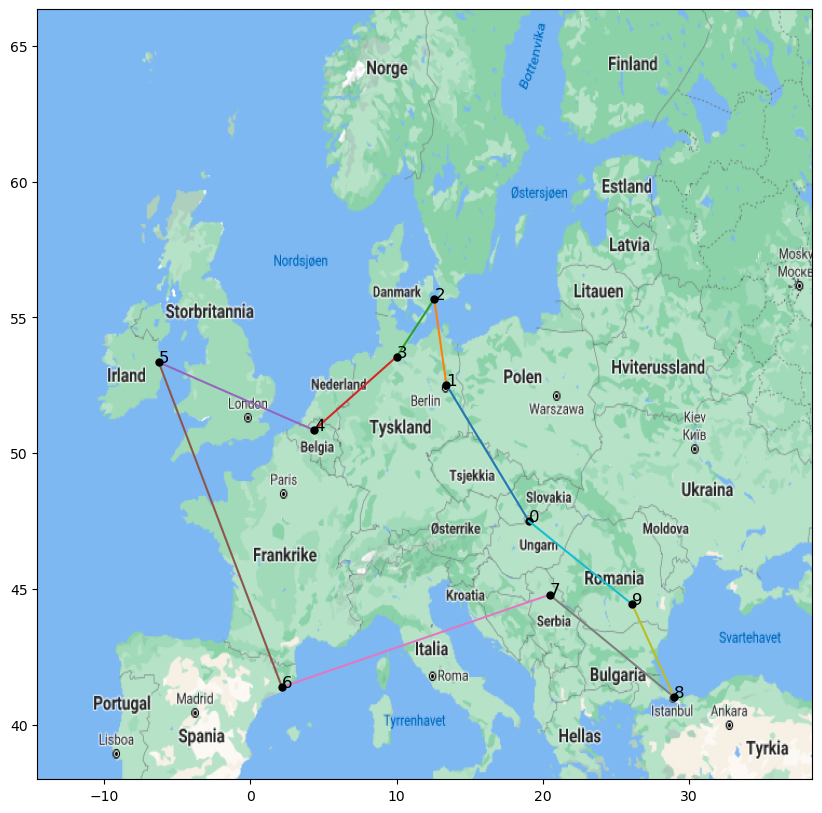

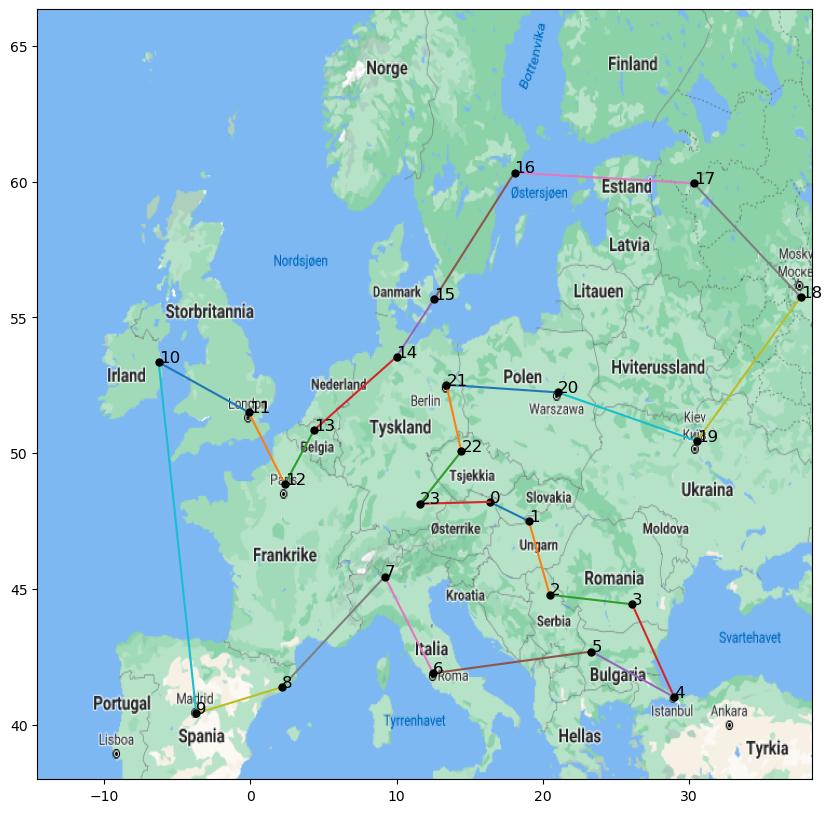

Best distance for 24 cities: 12287, fitness: 8.138636794614175e-05


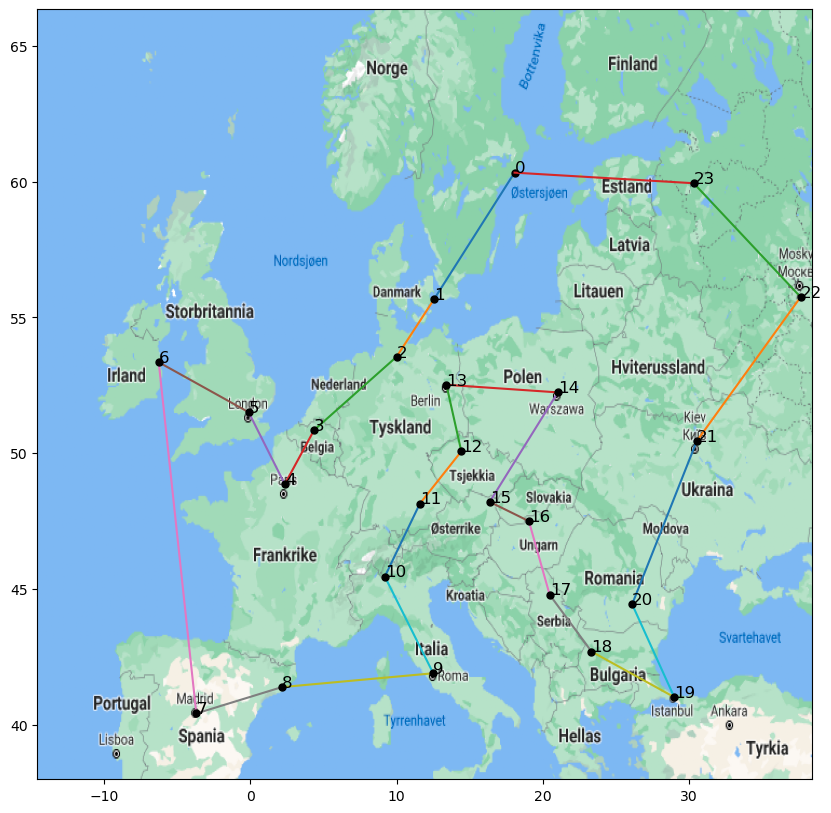

In [116]:
# Implement the algorithm here
 
# Swapping just neighbhor cities, save if it produces a better fit (shorter path).

# Start with 1 random route
#  swap 2 cities positions, (either neighbor or not) can try both
# (swap n times, which we can choose e.g 1e2 -> 1e4)
# claculate fitness/distance -> update if improved

# Do 20 differnet initalizations and run it.

# perm_1

def hill_climb(starting_route, max_iter):
    n = len(starting_route) # nr. of cities
    curr_path = np.array(starting_route) # current best path
    best_dist = calc_distance(curr_path)

    for i in range(max_iter):
        city1, city2 = random.sample(range(n), 2) #pick 2 random indices to swap
        curr_path[city1], curr_path[city2] = curr_path[city2], curr_path[city1]
        curr_dist = calc_distance(curr_path)

        if curr_dist < best_dist:
            best_dist = curr_dist
        else:
            curr_path[city1], curr_path[city2] = curr_path[city2], curr_path[city1] #swap back if not improved
        
    return curr_path, best_dist


def hill_iterate(permutations, n, max_iter=1000, printInfo = True):
    # Do hill climb n times
    # Find best, worst and mean path distance
    starting_paths = random.sample(permutations, n)
    m_cities = len(starting_paths[0])
    best_paths =  []
    best_dists = []

    for path in starting_paths:
        path, dist = hill_climb(path, max_iter)
        best_paths.append(path)
        best_dists.append(dist)

    best_paths = np.array(best_paths)
    best_dists = np.array(best_dists)

    min_i = np.argmin(best_dists)
    max_i = np.argmax(best_dists)

    mean = np.mean(best_dists)
    std_dev = np.std(best_dists)

    if printInfo:
        print(f"For {m_cities} cities:")
        print(f"Best distance: {best_dists[min_i]:.0f}, worst distance: {best_dists[max_i]:.0f}")
        print(f"Best path: {best_paths[min_i]}")
        print(f"Mean: {mean:.2f} , STD: {std_dev:.2f}\n")
    
    return best_paths[min_i], best_dists[min_i], best_paths[max_i], best_dists[max_i]

        
b6, _, _, _ = hill_iterate(perm_6, 20)
b10, _, _, _ = hill_iterate(perm_10, 20)
b24, _, _, _ = hill_iterate(perm_24, 20, int(1e4))

#plot_path(b6)
plot_path(b10)
plot_path(b24)

# Best run for 24 for 1e4 iterations with 20 samples: (12417, 12972, 12785, 13492, 12835, 13209, 12417, 13102)
# Best run for 24 for 1e5: (12718, 12691, 13011, 13137, )  # seemingly dont get much better than 1e4, and gets stuck somewhere

#Could make a plot showing distance in n x n matrix with iterations and number of samples in row and cols
def grid_search():
    n = 5
    m = 4
    iters = np.logspace(0, n-1, n, dtype=int)  # 1, 10, ..., 1e5
    print(iters)
    samples = np.linspace(1, 300, m, dtype=int)
    print(samples)
    
    dist_m = np.zeros((n, m))
    path_m = np.zeros((n, m), dtype=object)
    time_m = np.zeros((n, m)) 

    for i in range(len(iters)):
        for j in range(len(samples)):
            start_time = time.time() 
            path, dist, _, _ = hill_iterate(perm_24, samples[j], iters[i], printInfo=False)
            end_time = time.time()  
            time_m[i, j] = end_time - start_time
            dist_m[i, j] = dist
            path_m[i, j] = path
            

    print(f"Distance:\n{dist_m}")
    print(f"Time:\n{time_m}")
    print(f"Paths:\n{path_m}")
    
    return 0



# I wanted to see effect of increasing samples of runs vs number of iterations
#grid_search()

#Shortest path found from simple gridsearch (200 samples, 1e5 iterations)
path_best = np.array([21,  6,  8,  3, 16, 11,  7, 12,  0, 18, 13, 15, 17,  2, 23, 22,  5, 1, 20,  9,  4, 10, 14, 19])
dist = calc_distance(path_best)
print(f"Best distance for 24 cities: {dist:.0f}, fitness: {fitness(dist)}")
plot_path(path_best)



#### Did basic search to see effect of paramters, distance matrix with time table

Commment in grid_search() to run. But takes some time to run, and isnt asked for so i left it. Ideally id wanna run same values for x,y but took too long to run 1000 x 1000. 

The best run i found one time was 12287 (200 samples and 1e5 iterations). With path: (21,  6,  8,  3, 16, 11,  7, 12,  0, 18, 13, 15, 17,  2, 23, 22,  5, 1, 20,  9,  4, 10, 14, 19)

(used gpt to create nicely formatted table)
**Distance Table (Iterations: 1, 10, 100, 1000, 10000; Samples: 1, 100, 200, 300)**

|         | **1** | **100** | **200** | **300** |
|---------|-------|---------|---------|---------|
| **1**   | 34959 | 25667   | 25309   | 25423   |
| **10**  | 27489 | 22059   | 23575   | 22265   |
| **100** | 20816 | 16511   | 17436   | 16083   |
| **1000**| 13706 | 13224   | 12615   | 12951   |
| **10000**| 14329 | 12620   | 12287   | 12363   |

---

**Time Table (Iterations: 1, 10, 100, 1000, 10000; Samples: 1, 100, 200, 300)**

|         | **1**  | **100**  | **200**  | **300**  |
|---------|--------|----------|----------|----------|
| **1**   | 0.00   | 0.00     | 0.00     | 0.00     |
| **10**  | 0.00   | 0.01     | 0.03     | 0.04     |
| **100** | 0.00   | 0.12     | 0.24     | 0.35     |
| **1000**| 0.01   | 1.20     | 2.37     | 3.63     |
| **10000**| 0.12  | 11.86    | 23.89    | 35.10    |

## Genetic Algorithm
Next, write a genetic algorithm (GA) to solve the problem. Choose mutation and crossover operators that are appropriate for the problem (see chapter 4.5 of the Eiben and Smith textbook). Choose three different values for the population size. Define and tune other parameters yourself and make assumptions as necessary (and report them, of course).

For all three variants: As with the hill climber, report best, worst, mean and standard deviation of tour length out of 20 runs of the algorithm (of the best individual of last generation). Also, find and plot the average fitness of the best fit individual in each generation (average across runs), and include a figure with all three curves in the same plot in the report. This means that the x-axis should be the generations over time and the y-axis should be the average (over the 20-runs) fitness of the best gene in that generation. Conclude which is best in terms of tour length and number of generations of evolution time.

Finally, plot an example optimized tour (the best of the final generation) for the three different population sizes, using the plot_plan method.


Generation: 0, Fitness: 3.852923135724613e-05
Generation: 100, Fitness: 4.4140327397636394e-05
Generation: 200, Fitness: 4.4140327397636394e-05
Generation: 300, Fitness: 4.4140327397636394e-05
Generation: 400, Fitness: 4.483605249046338e-05
Generation: 500, Fitness: 4.7166807774033245e-05
Generation: 600, Fitness: 4.7166807774033245e-05
Generation: 700, Fitness: 4.7166807774033245e-05
Generation: 800, Fitness: 4.7166807774033245e-05
Generation: 900, Fitness: 4.7166807774033245e-05
[12  7  2 10  9 14 19  8 21  6  5 23 13  0  3 15 22  1 20  4 18 17 11 16]
Distance for path: 21201.35


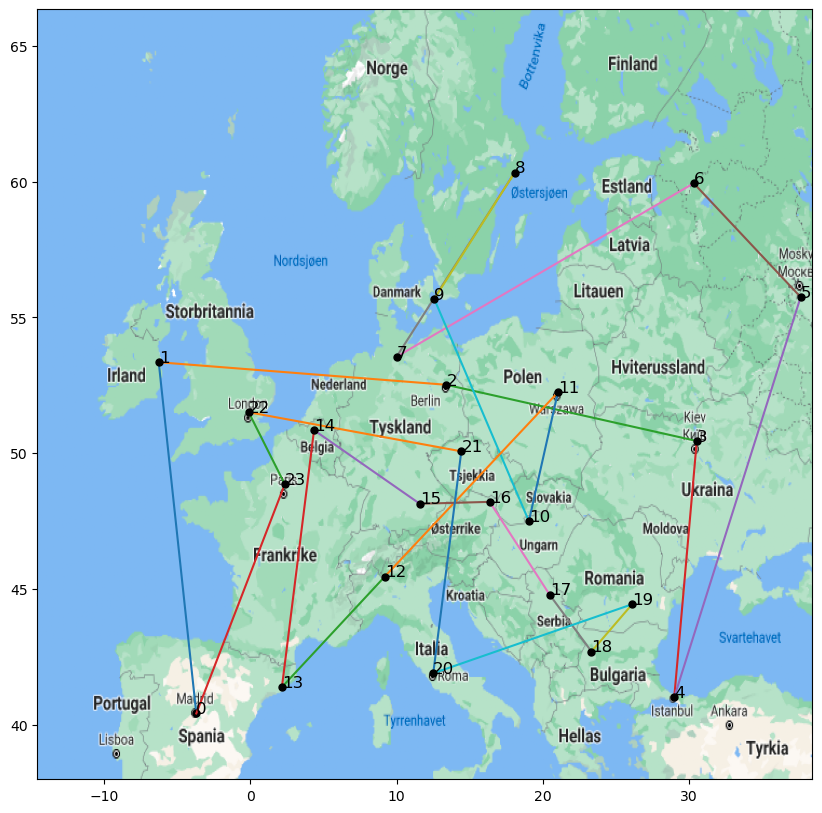

'\n# Params\npop_size = 500\ngenerations = 5000\nmutation_rate = 0.3\n\nGeneration: 0, Fitness: 4.0180103295009554e-05\nGeneration: 100, Fitness: 4.5029163137506005e-05\nGeneration: 200, Fitness: 4.5029163137506005e-05\nGeneration: 300, Fitness: 4.5029163137506005e-05\nGeneration: 400, Fitness: 4.7538594207707525e-05\nGeneration: 500, Fitness: 4.7538594207707525e-05\nGeneration: 600, Fitness: 4.7538594207707525e-05\nGeneration: 700, Fitness: 4.7538594207707525e-05\nGeneration: 800, Fitness: 4.7538594207707525e-05\nGeneration: 900, Fitness: 4.7538594207707525e-05\nGeneration: 1000, Fitness: 4.7538594207707525e-05\nGeneration: 1100, Fitness: 4.7538594207707525e-05\nGeneration: 1200, Fitness: 4.7538594207707525e-05\nGeneration: 1300, Fitness: 4.7538594207707525e-05\nGeneration: 1400, Fitness: 4.7538594207707525e-05\nGeneration: 1500, Fitness: 4.7538594207707525e-05\n\n...\nGeneration: 4800, Fitness: 4.854654084050568e-05\nGeneration: 4900, Fitness: 4.854654084050568e-05\n\nDistance for pa

In [232]:
# Implement the algorithm here

# Plot three curves, fitness function. Three populations: e.g: 15, 25, 35.
# Generations, e.g: 60
# Break main operations into functions: init_pop, fitness, select_parents, recombine, mutate

#Already have fitness-  Use by calc_distance(path) -> fitness(distance)

def fitness_pop(pop):
    # Calculate fitness function function and return list of whole population
    fit = [fitness(calc_distance(path)) for path in pop] # find fitness of each path in population
    return np.array(fit)

def init_pop(size, cities):
    ''' 
    Use already existing function to generate a new population of size with cities as path.
    '''
    pop = gen_perm(cities, size)
    return pop

def select_parents(pop, eval_pop):
    # Select which parents to pair up (exploration/exploitation), (rank based/roulette wheel)

    #Use roulette wheel selection: Individuals are selected with a probability proportional to their fitness.
    #                              Fitness values are normalised to create a probability distribution
    parent_pairs = []

    # Followed this structure: https://cratecode.com/info/roulette-wheel-selection

    tot_fit = np.sum(eval_pop)
    prob_scaled = eval_pop/tot_fit
    cumulative = np.cumsum(prob_scaled) # wheel slice sizes
    n = int(len(pop) / 2) # could vary but right now set as half of population, since i have replacement could generate infinite number of childs

    # Pick from roulette n pairs, could vary but right now set as half of population
    pairs = np.zeros((n, 2), dtype=object)

    for i in range(n):
        par1 =  select_one_roulette(pop, cumulative)
        par2 = select_one_roulette(pop, cumulative)
        pairs[i] = [par1, par2]
        
    return pairs

def select_one_roulette(pop_, cumulative_): # from code linked
        # Used to select one individual from the population
        rand = np.random.rand()  # generate a random number between 0 and 1
        for i, cp in enumerate(cumulative_):
            if rand <= cp:
                return pop_[i].copy() # ensure no issues with changing old individuals
            
def recombine(parent_pairs):
    # Recombine parent pairs with a method: Multi-point crossover/PMX/OX/Edge recombination

    ''' 
    Partially Mapped Crossover (PMX):
    It creates offspring by preserving the relative order of selected elements from both parents while filling in 
    theremaining positions based on the information from the parents.
    - Two random crossover points are chosen.
    - The segment between the crossover points is copied from one parent to the corresponding positions in theoffspring.
    - The remaining positions are filled by mapping the values from the other parent, ensuring no duplication

    or simple 

    N-point crossover-

    Decided to use ordered crossover, as it keeps order better than n_point crossover. PMX seemed difficult to implement
    '''
    def n_point_cross(p1, p2):
        return p1, p2
    
    # Not fully implemented, began but moved on to OX
    def pmx(p1, p2):
        index1,index2 = random.choice(p1) , random.choice(p1)
        p1[p1.index(index1):p1.index(index2)] , p2[p1.index(index1):p1.index(index2)] = p2[p1.index(index1):p1.index(index2)] , p1[p1.index(index1):p1.index(index2)]

        for i in p1[p1.index(index1):p1.index(index2)] not in p2[p1.index(index1):p1.index(index2)]:
            print(i)
        return p1, p2
    
    
    def ordered_cross(p1, p2):
        # Odrdered crossover which returns 1 child.
        # Take one substring out or parent one, then fill out rest as in order from p2. No duplicates
        n = len(p1)  # number of genes/cities in path
        child = np.full(n, -1)  # fill with -1 
        i1, i2 = sorted(random.sample(range(n), 2))  # crossover points
        child[i1:i2+1] = p1[i1:i2+1].copy()  # not sure if i need copy, but to be safe i did here. As dont want to change parent.

        # Used help from gpt to get a smarter logic to check for duplicates, my first idea of manually checking each element didnt work
        p2_i = 0
        for i in range(n):  # Ensure you loop over all positions in the child
            if child[i] == -1:  #meaning not filled in yet
                while p2[p2_i] in child:  # check for duplicates
                    p2_i += 1
                child[i] = p2[p2_i] # fill the spot with gene from parent 2

        return child

    #Implement the method for ccrossover on all parent pairs
    size = parent_pairs.shape[0] # same number of childs as parent pairs
    size_path = parent_pairs[0][0].shape[0] # length of path
    childs = np.zeros((size, size_path), dtype=int)

    for i, (p1_, p2_) in enumerate(parent_pairs):
        childs[i] = ordered_cross(p1_, p2_)
        #childs[i] = pmx(p1_, p2_)
        #print(f"Parent 1 {p1_}, Parent 2 {p2_}. Child: {childs[i]}")

    return childs

def mutate(childs, mut_rate):
    # Mutate child with mutation rate (mut_rate) with one method of: Bit flip/swap/inversion/gaussian
    n = len(childs[0]) # number of genes/cities in a path
    # Mutate by flipping two genes.
    for i in range(len(childs)):
        rand_ = random.uniform(0, 1)
        if mut_rate > rand_: #e.g if 0.2, want to flip 20% of the times
            index1, index2  = random.sample(range(n), 2) #pick 2 random indices to swap
            childs[i][index1], childs[i][index2] = childs[i][index2], childs[i][index1] # swap them
    
    return childs

def select_new_(parents, childs , evaled_parents , evaled_childs):
    # Combine whole old population (where parens are from) and combine with childs then use roulette again to select next generation starting
    # population. Make sure we keep same number of individuals each generation
    comb_pop = np.concatenate((parents, childs))
    comb_eval = np.concatenate((evaled_parents, evaled_childs))

    tot_fit = np.sum(comb_eval)
    prob_scaled = comb_eval/tot_fit
    cumulative = np.cumsum(prob_scaled) # wheel slice sizes

    # Want to keep pop size constant
    new_pop = np.zeros_like(parents)

    for i in range(parents.shape[0]):
        new_pop[i] = select_one_roulette(comb_pop, cumulative)

    new_eval = fitness_pop(new_pop) # prob a smarter way to make use of alrady existing evals, but awkward when using roulette

    return new_pop, new_eval

def select_new(parents, childs, evaled_parents, evaled_childs, elitism_rate=0.2):
    # GPT version with added elitism to see if i could fix 24 cities results, it did not. Also tried PMX
    # Combine parents and children into one population
    comb_pop = np.concatenate((parents, childs))
    comb_eval = np.concatenate((evaled_parents, evaled_childs))

    # Total population size and number of elite individuals to retain
    pop_size = parents.shape[0]
    num_elite = max(1, int(elitism_rate * pop_size))  # At least 1 elite

    # Sort combined population by fitness in descending order
    sorted_indices = np.argsort(comb_eval)[::-1]  # Sort by fitness
    elite_indices = sorted_indices[:num_elite]  # Get indices of elite individuals

    # Keep the elite individuals in the new population
    new_pop = np.zeros_like(parents)
    new_pop[:num_elite] = comb_pop[elite_indices]
    new_eval = np.zeros_like(evaled_parents)
    new_eval[:num_elite] = comb_eval[elite_indices]

    # Roulette wheel selection for the rest of the population
    tot_fit = np.sum(comb_eval)
    prob_scaled = comb_eval / tot_fit
    cumulative = np.cumsum(prob_scaled)

    # Fill the rest of the population with roulette wheel selection
    for i in range(num_elite, pop_size):
        new_pop[i] = select_one_roulette(comb_pop, cumulative)
        new_eval[i] = fitness_pop([new_pop[i]])[0]  # Evaluate the selected individual

    return new_pop, new_eval


def GA(cities, pop_size, mutation_rate, generations, printInfo=False):
    ''' 
    # initialize population randomly -> pick 100-500 paths
    # EVALUATE each candidate -> use fitness function

    # REPEAT (while or for) until condition is satisfied:
        # SELECT parents -> choosing which parents to pair up (explore -> rank based worst+best), (exploit -> roulette wheel)
                         -> (remove parents from dataset to select)
                         -> new population (new list), with elitism keep some best parents into new list
        # RECOMBINE pairs of parents -> (PMX / n-point crossover)
        # MUTATE resulting offspring -> e.g 30% -> 0.3 *(swap/insert/scramble)
        # EVALUATE new candidates -> 
        # SELECT new individuals for next generation

    # Keep parents and childs, but maintain same population size each generation.
    '''
    best_path = []
    best_fit = -1 # higher is better (1/distance)
    fit_hist = []

    print_interval = generations // 20 

    pop = init_pop(pop_size, cities) # init population 
    pop = np.array(pop) # change to array for operations
    eval_pop = fitness_pop(pop) # eval each candidate

    for i in range(generations):
        # SELECT PARENTS
        parent_pairs = select_parents(pop, eval_pop)

        # RECOMBINE
        children = recombine(parent_pairs)

        # MUTATE
        children = mutate(children, mutation_rate)

        # EVALUATE
        eval_children = fitness_pop(children)

        # SELECT NEW (old + new), and return evaluation of all
        new_population, new_eval = select_new_(pop, children, eval_pop, eval_children)

        #Find best path
        index = np.argmax(new_eval)
        fit = new_eval[index]

        #print(f"Fit: {fit}, pop_size = {new_population.shape[0]}")

        if fit > best_fit:
            best_fit = fit
            best_path = new_population[index]

        fit_hist.append(best_fit)
        
        if(i % 100 == 0):
            print(f"Generation: {i}, Fitness: {best_fit}")

    return best_path, best_fit, fit_hist



# Params
pop_size = 200
generations = 1000
mutation_rate = 0.1

path, fit, fitness_history = GA(cities_24, pop_size, mutation_rate, generations)

print(path)
print(f"Distance for path: {calc_distance(path):.2f}")

plot_path(path)

# Goal for fitness from hill climb: 8.138636794614175e-05

# GA is seemingly working for 6 and 10 cities. However it cannot find a good solution for 24.



'''
# Params
pop_size = 500
generations = 5000
mutation_rate = 0.3

Generation: 0, Fitness: 4.0180103295009554e-05
Generation: 100, Fitness: 4.5029163137506005e-05
Generation: 200, Fitness: 4.5029163137506005e-05
Generation: 300, Fitness: 4.5029163137506005e-05
Generation: 400, Fitness: 4.7538594207707525e-05
Generation: 500, Fitness: 4.7538594207707525e-05
Generation: 600, Fitness: 4.7538594207707525e-05
Generation: 700, Fitness: 4.7538594207707525e-05
Generation: 800, Fitness: 4.7538594207707525e-05
Generation: 900, Fitness: 4.7538594207707525e-05
Generation: 1000, Fitness: 4.7538594207707525e-05
Generation: 1100, Fitness: 4.7538594207707525e-05
Generation: 1200, Fitness: 4.7538594207707525e-05
Generation: 1300, Fitness: 4.7538594207707525e-05
Generation: 1400, Fitness: 4.7538594207707525e-05
Generation: 1500, Fitness: 4.7538594207707525e-05

...
Generation: 4800, Fitness: 4.854654084050568e-05
Generation: 4900, Fitness: 4.854654084050568e-05

Distance for path: 20598.79
''' 

Fitness history per generation: [3.852923135724613e-05, 4.093245776077353e-05, 4.093245776077353e-05, 4.093245776077353e-05, 4.093245776077353e-05, 4.093245776077353e-05, 4.093245776077353e-05, 4.093245776077353e-05, 4.093245776077353e-05, 4.093245776077353e-05, 4.093245776077353e-05, 4.093245776077353e-05, 4.093245776077353e-05, 4.4140327397636394e-05, 4.4140327397636394e-05, 4.4140327397636394e-05, 4.4140327397636394e-05, 4.4140327397636394e-05, 4.4140327397636394e-05, 4.4140327397636394e-05, 4.4140327397636394e-05, 4.4140327397636394e-05, 4.4140327397636394e-05, 4.4140327397636394e-05, 4.4140327397636394e-05, 4.4140327397636394e-05, 4.4140327397636394e-05, 4.4140327397636394e-05, 4.4140327397636394e-05, 4.4140327397636394e-05, 4.4140327397636394e-05, 4.4140327397636394e-05, 4.4140327397636394e-05, 4.4140327397636394e-05, 4.4140327397636394e-05, 4.4140327397636394e-05, 4.4140327397636394e-05, 4.4140327397636394e-05, 4.4140327397636394e-05, 4.4140327397636394e-05, 4.4140327397636394e-

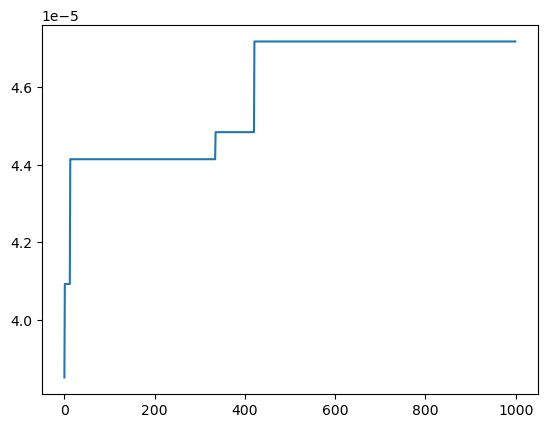

In [233]:
print(f"Fitness history per generation: {fitness_history}")
plt.plot(fitness_history)
plt.show()

Among the first 10 cities, did your GA find the shortest tour (as found by the exhaustive search)? Did it come close? 

For both 10 and 24 cities: How did the running time of your GA compare to that of the exhaustive search? 

How many tours were inspected by your GA as compared to by the exhaustive search?

In [234]:
# Answer